# Домашнее задание 2. Классификация, детекция.

Оценка за часть 1 и часть 2 в этом дз -- по 5 баллов.

## Часть 1. Классификация

В этом задании потребуется обучить классификатор изображений. Будем работать с датасетом, название которого раскрывать не будем. Можете посмотреть самостоятельно на картинки, которые в датасете есть. В нём 200 классов и около 5 тысяч картинок на каждый класс. Классы пронумерованы, как нетрудно догадаться, от 0 до 199. Скачать датасет можно вот [тут](https://yadi.sk/d/BNR41Vu3y0c7qA).

Структура датасета простая -- есть директории train и val, в которых лежат обучающие и валидационные данные. В train/ и val/ лежат директориии, соответствующие классам изображений, в которых лежат собственно сами изображения.
 
__Задание__. Добейтесь accuracy **не менее 0.44**. Напишите краткий отчёт о проделанных экспериментах. Что сработало и что не сработало? Почему вы решили, сделать так, а не иначе? Обязательно указывайте ссылки на чужой код, если вы его используете. Обязательно ссылайтесь на статьи/блогпосты/вопросы на stackoverflow/видосы от (индийских) ютуберов/курсы/подсказки от Дяди Васи и прочие дополнительные материалы, если вы их используете. 

В коде ниже необходимо, чтобы код проходил все `assert`'ы.

Необходимо написать функцию `predict` по шаблону ниже. Эта функция принимает на вход модель, даталоадер с валидационнами данными, criterion для подсчёта лосса и device, на котором будут производиться вычисления (определён ниже) и возвращает список лоссов по всем объектам, список из предсказанных классов для каждого объекта из даталоалера и список из настоящих классов для каждого объекта в даталоадере (и именно в таком порядке).

__Использовать внешние данные для обучения строго запрещено__. Можно использовать предобученные модели из `torchvision`.

__Критерии оценки__: Оценка вычисляется по простой формуле: min(5, 5 * Ваша accuracy / 0.44). Оценка округляется до десятых по арифметическим правилам.

__Советы и указания__:
 - Наверняка вам потребуется много гуглить о классификации и о том, как заставить её работать. Это нормально, все гуглят. Но не забывайте, что нужно быть готовым за скатанный код отвечать на защите :)
 - Используйте аугментации. Для этого пользуйтесь модулем torchvision.transforms или библиотекой [albumentations](https://github.com/albumentations-team/albumentations)
 - (ещё раз) Можно файнтюнить предобученные модели из `torchvision`.
 - Рекомендуем написать вам сначала класс-датасет (или воспользоваться классом ImageFolder), который возвращает картинки и соответствующие им классы, а затем функции для трейна по шаблонам ниже. Однако делать это мы не заставляем. Если вам так неудобно, то можете писать код в удобном стиле. Однако учтите, что чрезмерное изменение нижеперечисленных шаблонов увеличит количество вопросов к вашему коду и повысит вероятность вызова на защиту :)
 - Валидируйте. Трекайте ошибки как можно раньше, чтобы не тратить время впустую.
 - Чтобы отладить код, пробуйте обучаться на маленькой части датасета. Когда вы поняли, что смогли всё отдебажить, переходите обучению по всему датасету
 - На каждый запуск делайте ровно одно изменение в модели/аугментации/оптимайзере, чтобы понять, что и как влияет на результат.
 - Фиксируйте random seed.
 - Начинайте с простых моделей и постепенно переходите к сложным. Обучение лёгких моделей экономит много времени.
 - Ставьте расписание на learning rate. Уменьшайте его, когда лосс на валидации перестаёт убывать.
 - Советуем использовать гпу. Если у вас его нет, используйте google colab. Если вам неудобно его использовать на постоянной основе, напишите и отладьте весь код локально на CPU, а затем запустите уже написанный ноутбук в колабе. Авторское решение задания достигает требуемой точности в колабе за 15 минут обучения.
 
Good luck & have fun! :)

Материалы, которые я использовал:

* https://albumentations.ai/docs/examples/pytorch_classification/
* https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html

In [55]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
import numpy as np

from torchvision.models import resnet18, resnet152

from torchvision.datasets import ImageFolder

import torchvision.transforms as transforms
import PIL

import sys

from tqdm import tqdm as tqdm

from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
from IPython.display import clear_output

import pickle

In [27]:
train_transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomAffine(degrees=15),
        transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
        transforms.RandomGrayscale(),
        transforms.RandomRotation(degrees=45),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20, resample=PIL.Image.BILINEAR),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]
)

val_transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]
)

train_dataset = ImageFolder('./dataset/train', transform=train_transform)
val_dataset = ImageFolder('./dataset/val', transform=val_transform)

# train_dataset = MyDataset("./dataset/dataset/train", transform=train_transform)
# val_dataset = MyDataset("./dataset/dataset/val", transform=val_transform)
# REPLACE ./dataset/dataset WITH THE FOLDER WHERE YOU DOWNLOADED AND UNZIPPED THE DATASET
# OR USE torchvision.datasets.ImageFolder INSTEAD OF MyDataset

In [28]:
# Just very simple checks
assert isinstance(train_dataset[0], tuple)
assert len(train_dataset[0]) == 2
assert isinstance(train_dataset[1][1], int)
print("tests passed")

tests passed


In [29]:
def plot_history(train_history, val_history, title='loss'):
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(train_history, label='train', zorder=1)
    
    points = np.array(val_history)
    steps = list(range(0, len(train_history) + 1, int(len(train_history) / len(val_history))))[1:]
    
    plt.scatter(steps, val_history, marker='+', s=180, c='orange', label='val', zorder=2)
    plt.xlabel('train steps')
    
    plt.legend(loc='best')
    plt.grid()

    plt.show()

In [52]:
def train_one_epoch(model, train_dataloader, criterion, optimizer, device="cuda:0", return_log=False):
    model.train()
    total_loss = 0
    num_batches = 0
    all_losses = []
    acc_log = []
    total_predictions = np.array([])#.reshape((0, ))
    total_labels = np.array([])#.reshape((0, ))
    with tqdm(total=len(train_dataloader), file=sys.stdout) as prbar:
        for images, labels in train_dataloader:
            # Move Batch to GPU
            images = images.to(device)
            labels = labels.to(device)
            predicted = model(images)
            loss = criterion(predicted, labels)
            # Update weights
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            # Update description for tqdm
            accuracy = (predicted.argmax(1) == labels).float().mean()
            prbar.set_description(
                f"Loss: {round(loss.item(), 4)} "
                f"Accuracy: {round(accuracy.item() * 100, 4)}"
            )
            prbar.update(1)
            total_loss += loss.item()
            total_predictions = np.append(total_predictions, predicted.argmax(1).cpu().detach().numpy())
            total_labels = np.append(total_labels, labels.cpu().detach().numpy())
            num_batches += 1
            all_losses.append(loss.detach().item())
            acc_log.append(accuracy.detach().item())
    metrics = {'loss': total_loss / num_batches}
    metrics.update({"accuracy": (total_predictions == total_labels).mean()})
    if return_log:
        return metrics, all_losses, acc_log
    else:
        return metrics


def predict(model, val_dataloader, criterion, device="cuda:0"):
    model.eval()
    total_loss = 0
    num_batches = 0
    total_predictions = np.array([])
    total_labels = np.array([])
    with tqdm(total=len(val_dataloader), file=sys.stdout) as prbar:
        for images, labels in val_dataloader:
            images = images.to(device)
            labels = labels.to(device)
            predicted = model(images)
            loss = criterion(predicted, labels)
            accuracy = (predicted.argmax(1) == labels).float().mean()
            prbar.set_description(
                f"Loss: {round(loss.item(), 4)} "
                f"Accuracy: {round(accuracy.item() * 100, 4)}"
            )
            prbar.update(1)
            total_loss += loss.item()
            total_predictions = np.append(total_predictions, predicted.argmax(1).cpu().detach().numpy())
            total_labels = np.append(total_labels, labels.cpu().detach().numpy())
            num_batches += 1
    metrics = {'loss': total_loss / num_batches}
    metrics.update({'accuracy': (total_predictions == total_labels).mean()})
    # predict val_dataloader and print and return the validation accuracy
    predicted_classes = total_predictions
    true_classes = total_labels
    return metrics, predicted_classes, true_classes


def train(model, train_dataloader, val_dataloader, criterion, optimizer, device="cuda:0", n_epochs=10, scheduler=None):
    all_train_losses = []
    epoch_train_losses = []
    epoch_eval_losses = []
    train_acc_log = []
    eval_acc_log = []
    for epoch in n_epochs:
        # Train step
        print(f"Train Epoch: {epoch}")
        train_metrics, one_epoch_train_losses, one_epoch_acc_log = train_one_epoch(
            model=model,
            train_dataloader=train_dataloader,
            optimizer=optimizer,
            return_log=True,
            criterion=criterion
        )
        # Save train losses
        all_train_losses.extend(one_epoch_train_losses)
        epoch_train_losses.append(train_metrics['loss'])
        # Save train accuracy log
        train_acc_log.extend(one_epoch_acc_log)
        # Eval step
        print(f"Validation Epoch: {epoch}")
        with torch.no_grad():
            validation_metrics = predict(
                model=model,
                val_dataloader=val_dataloader,
                criterion=criterion
            )[0]
        # Save eval losses
        epoch_eval_losses.append(validation_metrics['loss'])
        # Save eval accuracy
        eval_acc_log.append(validation_metrics['accuracy'])
        # Take scheduler step
        scheduler.step()
        # Plot loss and accuracy
        clear_output()
        plot_history(all_train_losses, epoch_eval_losses, 'loss')
        plot_history(train_acc_log, eval_acc_log, 'accuracy')
        # Train, evaluate, print accuracy, make a step of scheduler or whatever you want...

In [36]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

model = resnet152(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Linear(2048, 200)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [37]:
optimizer = torch.optim.Adam(model.fc.parameters(), 1e-4)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=256, shuffle=True)
criterion = nn.CrossEntropyLoss()
lambda1 = lambda epoch: 0.95 ** epoch
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)
n_epochs = range(10)

Простой тест на проверку правильности написанного кода

In [38]:
all_losses, predicted_labels, true_labels = predict(model, val_dataloader, criterion, device)
assert len(predicted_labels) == len(val_dataset)
accuracy = accuracy_score(predicted_labels, true_labels)
print("tests passed")

Loss: 5.4822 Accuracy: 0.0: 100%|██████████████████████████████████████████████████████| 40/40 [00:50<00:00,  1.26s/it]
tests passed


Запустить обучение можно в ячейке ниже.

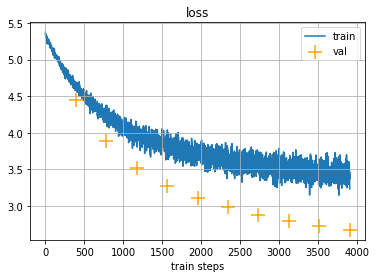

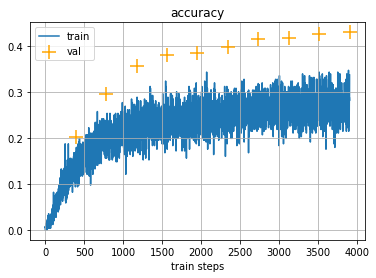

In [39]:
train(model, train_dataloader, val_dataloader, criterion, optimizer, device, n_epochs, scheduler)

После всех экспериментов, которые вы проделали, выберите лучшую из своих моделей, запустите функцию evaluate. Эта функция должна брать на вход модель и даталоадер с валидационными данными и возврашать accuracy, посчитанную на этом датасете.

После 10 эпох получили accuracy 0.43. Попробуем дообучить еще 1-2 эпохи.

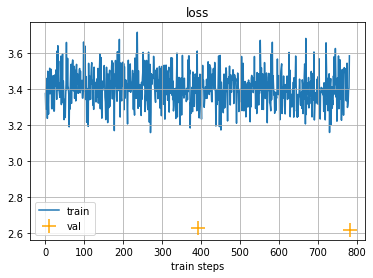

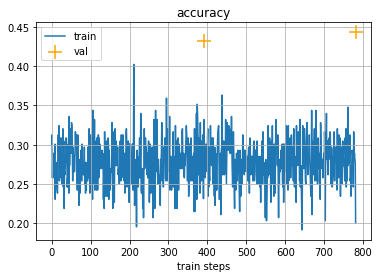

In [53]:
n_epochs_2 = range(10, 12)

train(model, train_dataloader, val_dataloader, criterion, optimizer, device, n_epochs_2, scheduler)

In [54]:
all_losses, predicted_labels, true_labels = predict(model, val_dataloader, criterion, device)
assert len(predicted_labels) == len(val_dataset)
accuracy = accuracy_score(true_labels, predicted_labels)
print(f'Accuracy составила {accuracy}')
print("Оценка за это задание составит {} баллов".format(min(5, 5*accuracy / 0.44)))

Loss: 2.8588 Accuracy: 31.25: 100%|████████████████████████████████████████████████████| 40/40 [00:51<00:00,  1.28s/it]
Accuracy составила 0.4433
Оценка за это задание составит 5 баллов


__Ваш отчёт о проделанных экспериментах__: я начал с предобученной ResNet18 и обучал последний полносвязный слой. После 8 эпох она выдавала качество accuracy около 0.25 и больше не обучалась (однако надо учесть, что при обучении ResNet я забыл нормализовать картинки). Тогда я решил увеличить количество слоев и взял ResNet152. После 10 эпох она выдала accuracy 0.43, а после 12 -- 0.43. Во всех случаях я применял к картинкам из train различные аугментации. Я использовал расписание на скорость обучения: learning rate составлял 0.95 в степени номера эпохи.

In [56]:
with open('task_1_model.pickle', 'wb') as f:
    pickle.dump(model, f)

## Часть 2. Object detection.

В этом задании потребуется обучить детектор фруктов на изображении. Датасет можно скачать [отсюда](https://yadi.sk/d/UPwQB7OZrB48qQ).

Материалы, которые я использовал:

* https://albumentations.ai/docs/examples/example_bboxes/
* https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html

In [1]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
import xmltodict
import json
import glob
import cv2
import os
import torchvision
import matplotlib.pyplot as plt
from sklearn.metrics import auc

import xmltodict, json

import albumentations as A
from albumentations.pytorch import ToTensorV2

from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [2]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda', index=0)

In [3]:
# we will need this library to process the labeling
# ! pip install xmltodict

Датасет мы за вас написали.

In [4]:
class2tag = {"apple": 1, "orange": 2, "banana": 3}


class FruitDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.images = []
        self.annotations = []
        self.transform = transform
        for annotation in glob.glob(data_dir + "/*xml"):
            image_fname = os.path.splitext(annotation)[0] + ".jpg"
            self.images.append(cv2.cvtColor(cv2.imread(image_fname), cv2.COLOR_BGR2RGB))
            with open(annotation) as f:
                annotation_dict = xmltodict.parse(f.read())
            bboxes = []
            labels = []
            objects = annotation_dict["annotation"]["object"]
            if not isinstance(objects, list):
                objects = [objects]
            for obj in objects:
                bndbox = obj["bndbox"]
                bbox = [bndbox["xmin"], bndbox["ymin"], bndbox["xmax"], bndbox["ymax"]]
                bbox = list(map(int, bbox))
                bboxes.append(torch.tensor(bbox))
                labels.append(class2tag[obj["name"]])
            self.annotations.append(
                {"boxes": torch.stack(bboxes).float(), "labels": torch.tensor(labels)}
            )

    def __getitem__(self, i):
        if self.transform:
            # the following code is correct if you use albumentations
            # if you use torchvision transforms you have to modify it =)
            res = self.transform(
                image=self.images[i],
                bboxes=self.annotations[i]["boxes"],
                labels=self.annotations[i]["labels"],
            )
            return res["image"], {
                "boxes": torch.tensor(res["bboxes"]),
                "labels": torch.tensor(res["labels"]),
            }
        else:
            return self.images[i], self.annotations[i]

    def __len__(self):
        return len(self.images)

Выпишем кое-какую техническую работу, которая уже была на семинаре.

In [5]:
def intersection_over_union(dt_bbox, gt_bbox):
    """
    Intersection over Union between two bboxes
    :param dt_bbox: list or numpy array of size (4,) [x0, y0, x1, y1]
    :param gt_bbox: list or numpy array of size (4,) [x0, y0, x1, y1]
    :return : intersection over union
    """

    ## TODO YOUR CODE

    intersection_bbox = np.array(
        [
            max(dt_bbox[0], gt_bbox[0]),
            max(dt_bbox[1], gt_bbox[1]),
            min(dt_bbox[2], gt_bbox[2]),
            min(dt_bbox[3], gt_bbox[3]),
        ]
    )

    intersection_area = max(intersection_bbox[2] - intersection_bbox[0], 0) * max(
        intersection_bbox[3] - intersection_bbox[1], 0
    )
    area_dt = (dt_bbox[2] - dt_bbox[0]) * (dt_bbox[3] - dt_bbox[1])
    area_gt = (gt_bbox[2] - gt_bbox[0]) * (gt_bbox[3] - gt_bbox[1])

    union_area = area_dt + area_gt - intersection_area

    iou = intersection_area / union_area
    return iou

def evaluate_sample(target_pred, target_true, iou_threshold=0.5):
    gt_bboxes = target_true["boxes"].numpy()
    gt_labels = target_true["labels"].numpy()

    dt_bboxes = target_pred["boxes"].numpy()
    dt_labels = target_pred["labels"].numpy()
    dt_scores = target_pred["scores"].numpy()
    
    results = []
    for detection_id in range(len(dt_labels)):
        dt_bbox = dt_bboxes[detection_id, :]
        dt_label = dt_labels[detection_id]
        dt_score = dt_scores[detection_id]

        detection_result_dict = {"score": dt_score}

        max_IoU = 0
        max_gt_id = -1
        for gt_id in range(len(gt_labels)):
            gt_bbox = gt_bboxes[gt_id, :]
            gt_label = gt_labels[gt_id]

            if gt_label != dt_label:
                continue

            if intersection_over_union(dt_bbox, gt_bbox) > max_IoU:
                max_IoU = intersection_over_union(dt_bbox, gt_bbox)
                max_gt_id = gt_id

        if max_gt_id >= 0 and max_IoU >= iou_threshold:
            detection_result_dict["TP"] = 1
            gt_labels = np.delete(gt_labels, max_gt_id, axis=0)
            gt_bboxes = np.delete(gt_bboxes, max_gt_id, axis=0)

        else:
            detection_result_dict["TP"] = 0

        results.append(detection_result_dict)

    return results


def evaluate(model, test_loader, device):
    results = []
    model.eval()
    nbr_boxes = 0
    print(test_loader)
    with torch.no_grad():
        for batch, (images, targets_true) in enumerate(test_loader):
            images = list(image.to(device).float() for image in images)
            print(images)
            targets_pred = model(images)
            targets_true = [
                {k: v.cpu().float() for k, v in t.items()} for t in targets_true
            ]
            targets_pred = [
                {k: v.cpu().float() for k, v in t.items()} for t in targets_pred
            ]

            for i in range(len(targets_true)):
                target_true = targets_true[i]
                target_pred = targets_pred[i]
                nbr_boxes += target_true["labels"].shape[0]

                results.extend(evaluate_sample(target_pred, target_true))

    results = sorted(results, key=lambda k: k["score"], reverse=True)

    acc_TP = np.zeros(len(results))
    acc_FP = np.zeros(len(results))
    recall = np.zeros(len(results))
    precision = np.zeros(len(results))

    if results[0]["TP"] == 1:
        acc_TP[0] = 1
    else:
        acc_FP[0] = 1

    for i in range(1, len(results)):
        acc_TP[i] = results[i]["TP"] + acc_TP[i - 1]
        acc_FP[i] = (1 - results[i]["TP"]) + acc_FP[i - 1]

        precision[i] = acc_TP[i] / (acc_TP[i] + acc_FP[i])
        recall[i] = acc_TP[i] / nbr_boxes

    return auc(recall, precision)

Вам мы оставляем творческую часть =)

__Задание__. Обучите модель для object detection на __обучающем__ датасете и добейтесь PR-AUC не менее __0.91__ на  __тестовом__.

 - Создайте модель и оптимайзер
 - Напишите функцию обучения модели
 - Используйте аугментации
 
Использовать аугментации для обучения __обязательно__. Они дадут 1 балл из 5. Пользуйтесь модулем torchvision.transforms или библиотекой albumentations (о которой говорилось ранее). Последняя библиотека особенно удобна, поскольку умеет сама вычислять новые координаты bounding box'ов после трансформаций картинки. Советуем обратить внимание на следующий [гайд](https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/). Обратите внимание, что код, написанный в датасете выше, верен только если вы используете albumentations. Если вы выбрали путь torchvision.transforms, вам потребуется метод `__getitem__` изменить (что-то типа `return self.transform(self.images[i])`; однако в таком случае вычислять новые координаты bounding box'ов после трансформаций вам придётся вручную =))

Оставшиеся 4 балла вычисляются по простой формуле: __min(4, 4 * Ваш auc / 0.91)__.

In [6]:
def train_one_epoch(model, train_dataloader, optimizer, device):
    model.train()
    n = 0
    global_loss = 0
    print(train_dataloader)
    for images, targets in train_dataloader:
        images = list(image.to(device).float() for image in images)
        print(images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        dict_loss = model(images, targets)
        losses = sum(loss for loss in dict_loss.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        n += 1
        global_loss += float(losses.cpu().detach().numpy())

        if n % 10 == 0:
            print("Loss value after {} batches is {}".format(n, round(global_loss / n, 2)))

    return global_loss
    pass


def train(model, train_dataloader, val_dataloader, optimizer, device, n_epochs=10):
    for epoch in range(n_epochs):
        model.eval()
        a = evaluate(model, val_dataloader, device=device)
        print("AUC ON TEST: {.4f}".format(a))
        model.train()
        train_one_epoch(model, dataloader, optimizer, device=device)

In [7]:
train_transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(p=0.5),
        A.RandomBrightnessContrast(p=0.3),
        A.RGBShift(r_shift_limit=30, g_shift_limit=30, b_shift_limit=30, p=0.3),
        ToTensorV2()
    ],
    bbox_params=A.BboxParams(format='pascal_voc', min_visibility=0.3, label_fields=['labels']),
)
val_transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        ToTensorV2()
    ],
    bbox_params=A.BboxParams(format='pascal_voc', min_visibility=0.3, label_fields=['labels']),
)
# HINT: TRAIN TRANSFORM OBVIOUSLY SHOULD BE HARDER THAN THOSE FOR VALIDATION

train_dataset = FruitDataset("./archive/train_zip/train", transform=None)
val_dataset = FruitDataset("./archive/test_zip/test", transform=None)

In [8]:
model = fasterrcnn_resnet50_fpn(pretrained=True)
num_classes = 3
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]

# HINT: USE MATERIALS FROM THE SEMINAR
# YOU CAN USE torchvision.models AND torchvision.models.detection
# READ OFFICIAL DOCS FOR MORE INFO

In [9]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [10]:
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=2, shuffle=True, num_workers=4, collate_fn=collate_fn)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=1, shuffle=False, num_workers=4, collate_fn=collate_fn)
n_epochs = 5

In [11]:
image, labels = next(iter(val_dataset))
image

array([[[204, 230, 229],
        [206, 232, 231],
        [213, 239, 240],
        ...,
        [192, 202, 131],
        [230, 237, 160],
        [211, 214, 135]],

       [[197, 221, 223],
        [198, 222, 224],
        [209, 233, 235],
        ...,
        [157, 169, 103],
        [208, 218, 145],
        [203, 210, 130]],

       [[187, 211, 215],
        [189, 212, 218],
        [207, 230, 236],
        ...,
        [119, 134,  75],
        [185, 198, 129],
        [203, 214, 136]],

       ...,

       [[ 71,  81,  46],
        [126, 136,  86],
        [154, 160,  98],
        ...,
        [ 27,  46,   1],
        [ 56,  76,  23],
        [ 88, 108,  49]],

       [[ 78,  92,  57],
        [110, 122,  76],
        [130, 139,  82],
        ...,
        [ 15,  47,  10],
        [ 55,  87,  40],
        [ 97, 127,  73]],

       [[ 81,  95,  60],
        [ 98, 111,  67],
        [107, 120,  67],
        ...,
        [ 18,  58,  23],
        [ 62, 101,  56],
        [ 94, 131,  79]]

In [12]:
# # For Training
# images,targets = next(iter(train_dataloader))
# images = list(image for image in images)
# targets = [{k: v for k, v in t.items()} for t in targets]
# output = model(images,targets)   # Returns losses and detections
# # For inference
# model.eval()
# x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
# predictions = model(x)      

In [ ]:
train(model, train_dataloader, val_dataloader, optimizer, device, n_epochs)

__Выведите итоговое качество модели__.

In [ ]:
auc = evaluate(model, val_dataloader, criterion)
print("Оценка за это задание составит {} баллов".format(min(4, 4 * auc / 0.91)))

Нарисуйте предсказанные bounding box'ы для любых двух картинок из __тестового__ датасета.

In [15]:
image, labels = next(iter(train_dataset))
pred = model(image.unsqueeze(0).to(device))[0]

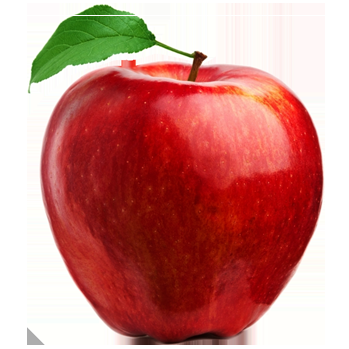

In [16]:
from PIL import ImageDraw

image = torchvision.transforms.ToPILImage()(image)
draw = ImageDraw.Draw(image)
for box in labels['boxes']:
    draw.rectangle([(box[0], box[1]), (box[2], box[3])])
    
for box in pred['boxes']:
    draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline='red')
image

## Бонус (10 баллов).

__Задание__. В части с классификацией добейтесь выполнения хотя бы одного из перечисленных критериев:
 - Достичь accuracy не менее 0.56, **не используя resize картинок**, а также **не используя предобученные сети**;
 - Достичь accuracy не менее 0.86, но использовать resize и предобученные из torchvision сети разрешается. 
 
Напишите отчёт о проделанных экспериментах.

__Критерии оценки__. Оценка за бонусную часть равна 10, если вы выполнили хоть один из вышеперечисленных критериев и 0 в противном случае.

__Иных оценок кроме 0 и 10 не предусмотрено__.

In [ ]:
# YOUR CODE

## Бонус (0 баллов).

__Задание 1__. Скиньте ниже смешную картинку, желательно про машинное обучение. На картинке не должно быть никаких упоминаний лектора, семинаристов и ассистентов этого курса.

__Задание 2__. Расскажите, как вам задание? Что понравилось, что не понравилось, что можно улучшить? Мы примем во внимание любой фидбек.